  av_training_set  tce_period  tce_duration  tce_time0bk    kepid  \
0             AFP    0.831850         2.392      132.227  1162345   
3             AFP    0.831833         2.181      131.919  1162345   
5              PC    8.884920         2.078      134.452   757450   
6             NTP    2.262110         7.509      132.171   892667   
7             AFP    5.092600         3.399      133.451   892772   

   tce_plnt_num  
0             2  
3             3  
5             1  
6             1  
7             1  


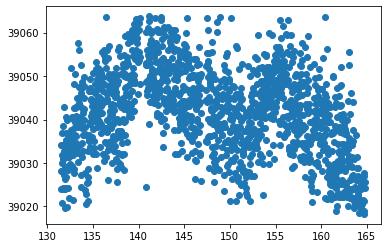

orbital_period 0.8247700102694752
planet_radius_sr 0.013562928126727335
orbital_radius_sr 191.4488332867749


AttributeError: module 'batman' has no attribute 'TransitParams'

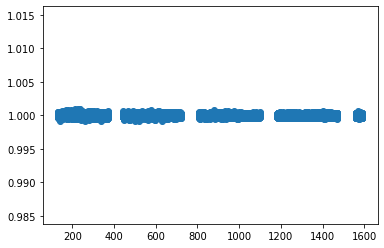

In [1]:
from preprocess.preprocess import *
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import time
import pickle
# from lightkurve import *
TCE_DIR = "dr24_tce_full.csv"
KEPLER_DATA_DIR = "../../kepler/"
FIG_DIM = (20, 10)
TCE_DIR = "dr24_tce_full.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=159)
cols = ["av_training_set", "tce_period", "tce_duration", "tce_time0bk", "kepid", "tce_plnt_num"]
tce_df = tce_df[cols]
tce_df = tce_df[tce_df.av_training_set.isin(["AFP", "NTP", "PC"])]
print(tce_df.head())

import batman
import lightkurve
from Engine import *

def reject_outliers(time, data, m = 3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    filt = s<m
    return time[filt], data[filt]

def inject_transit(kepid):

    tce = tce_df[tce_df.kepid == kepid].iloc[0]
    period = tce["tce_period"]
    duration = tce["tce_duration"]
    t0 = tce["tce_time0bk"]
    kepid = tce["kepid"]
    planet_num = tce["tce_plnt_num"]
    train_set = tce["av_training_set"]
    
    all_time, all_flux = read_light_curve(kepid, KEPLER_DATA_DIR)
#     time, flux = process_light_curve(all_time, all_flux)
    
    filtered_time, filtered_flux = [], []
    for i in range(len(all_time)):
        t, f = reject_outliers(all_time[i], all_flux[i])
        filtered_time.append(t)
        filtered_flux.append(f)
        
    plt.scatter(filtered_time[0], filtered_flux[0])
    plt.show()
    time, flux = process_light_curve(filtered_time, filtered_flux)
    
    plt.scatter(time, flux)
    
    get_transit(5700, (time/365.25))
    
    folded_time, folded_values = phase_fold_and_sort_light_curve(time, flux, period, t0)
    
    return folded_time, folded_values, period, duration, planet_num, train_set

def scatter_lg(d, label, ax, xlbl=None, title=None):
    ax.scatter(np.arange(-0.5, 0.5, 1/len(d)), d, label=label)
    ax.set_ylabel("Normalized flux")
    if xlbl:
        ax.set_xlabel(xlbl)
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    
    
def save_local_global_of_row_index(kepid):
    folded_time, folded_values, period, duration, planet_num, train_set = get_normalized_curve_from_kid(kepid)
    g = global_view(folded_time, folded_values, period)
    l = local_view(folded_time, folded_values, period, duration)
    fig, axs = plt.subplots(2, sharex=True, figsize=FIG_DIM)
    scatter_lg(g, "Global View", axs[0], title="TCE {}-{}".format(kepid, planet_num))
    scatter_lg(l, "Local View", axs[1], xlbl="Phase-folded datapoints, centered at t0")
# save_local_global_of_row_index(13)

# 11442793

inject_transit(11442793)

    